# Personal Information
Name: **Joely Lin**

StudentID: **13626914**

Email: [**joely.lin@student.uva.nl**](youremail@student.uva.nl)

Submitted on: **30.03.2025**

# Data Context
This study employs the ShanghaiTech Campus dataset, a widely used benchmark for video-based anomaly detection in surveillance contexts. The dataset comprises video sequences captured from 13 distinct outdoor campus scenes using fixed surveillance cameras. Each scene features both normal and anomalous human activities, with anomalies such as running, fighting, or riding bicycles in pedestrian zones annotated via temporal and spatial bounding boxes.

# Dataset Description – ShanghaiTech Campus Dataset

**Source:** https://svip-lab.github.io/dataset/campus_dataset.html , https://github.com/stevenliuwen/ano_pred_cvpr2018?tab=readme-ov-file 

The ShanghaiTech Campus Dataset is a widely used benchmark for video anomaly detection, introduced by Liu et al. (CVPR 2018). It is designed to support both frame-level and pixel-level anomaly detection under real-world surveillance settings. The dataset captures human and vehicle activity from fixed surveillance cameras across 13 outdoor scenes on a university campus. These scenes vary in background, lighting, and angle  providing a challenging and diverse environment for anomaly detection tasks.
The dataset is split into two subsets:

**Training Set:** Contains only normal (non-anomalous) activity and is intended for unsupervised or weakly supervised learning of normality. (videos)
**Testing Set:** Includes both normal and anomalous events, with annotations available at both the frame level and the pixel level. (frames)

Frame-level labels provide a binary indicator of anomaly presence per frame, while pixel-level masks identify the spatial extent of anomalies using binary segmentation masks. All frames in the testing set have a resolution of 856 × 480, though some minor variation exists in the training set. The remainder of the EDA will focus solely on the testing dataset, as the training dataset contains only videos and we are not using unsupervised learning.

### Corpus Summary 
According to the official paper the full dataset comprises 330 training videos and 107 testing video clips with 130 abnormal events across 13 scenes, totaling 49,071 frames, of which 6,913 are labeled as anomalous. Frame counts per scene range from approximately 190 to over 900 frames. This seems to be untrue for the distributed dataset. I’ve confirmed that the distributed version from the official publishings both personal and academic, are identical and differ from the paper's description.

The testing set consists of 107 video clips across 12 scenes, totaling 40,791 frames, of which 17,326 are labeled as anomalous. Since anomalies are labeled at the frame level rather than as discrete events, the anomalous frames were grouped into segments to enable temporal analysis. An anomaly segment is defined as a contiguous sequence of anomalous frames, allowing for short gaps of up to 10 normal frames. The number of segments per scene ranges from 0 to over 3, with some individual segments lasting 539 frames, indicating extended anomalous activity. The local dataset ended up having 131 anomaly segments.

### Data Integrity and Scene Coverage

During preprocessing, a subset of scenes listed in missing_scence.csv was found to be absent from the local distribution. This includes Scene 13, which is entirely missing, and Scene 11, which contains only a single usable instance. These scenes could not be recovered and are excluded from the analysis. Importantly, this absence is not due to file corruption or read errors, but reflects a discrepancy between the official dataset statistics and the actual distributed files.

All remaining scenes were verified and validated:
- All image frames were present and readable.
- Pixel-level masks existed for each frame and matched the number of frames in each scene.
- No malformed files, corrupted data, or inconsistent labeling were found.

The absence of these scenes results in a lower total frame count than reported in the original dataset publication. However, the remaining dataset is complete, structurally consistent, and provides sufficient variability and coverage for robust anomaly detection.
Given that the missing scenes are irrecoverable and no partial data exists for them, they are excluded from both analysis and model training. This decision is justified as the retained scenes constitute a complete and coherent subset of the full dataset. The remaining data offers sufficient volume and diversity to support statistically valid modeling. This approach also ensures compatibility with methods that require temporal and spatial consistency across frame sequences and pixel-level annotations.

### Anomaly Distribution Considerations
While verifying data integrity, several scenes were found to have a high proportion of anomalous frames. These scenes have been flagged for further review. Depending on the experimental design, they may be excluded, downweighted, or stratified during model training and evaluation to avoid skewing performance metrics.

### Variable-Level Observations and disctription
EDA was performed on both a scene and frame level.

**Scene level**

- Total Frames: Number of frames per scene segment. (range: 193 to 937 frames)
- Anomalous Frames: Number of frames labeled as anomalous (based on frame-level labels). (Range: 47 to 539 anomalous frames)
- Anomaly Segments: Number of contiguous anomaly segments per scene, allowing gaps of ≤10 normal frames. Typically fixed at 1 per scene (min = 1, max = 3) Suggests that most anomaly clips are treated as one continuous event.
- Longest Anomaly: Length (in frames) of the longest anomaly segment. (range: 44 to 539 frames)
- Avg Brightness / Min / Max Brightness: Grayscale brightness statistics (0–255 range) per scene. (Mean = 123.5, Std Dev = 6.6) mild variability in lighting across scenes.
- Brightness Std: Standard deviation of brightness per scene. (range: 0.22 to 5.29) Reflects dynamic activity (e.g., shadows, motion) and lighting changes.
- Avg Anomaly Size (px): Mean number of anomaly-labeled pixels per frame (only for anomalous frames). (range: ~239 to ~28,490 pixels) High variance suggests anomalies vary from small objects to large moving entities.
- Avg number of Blobs per Frame: Mean number of connected components (anomaly blobs) per frame. (range: ~0.09 to ~1.68)
  
**Frame level**
  
- Anomalous: A binary indicator of whether the frame is considered anomalous.
- Anomaly Pixels: identical to anomaly size
- Blob Count: The number of connected components (blobs) found in the binary anomaly mask for the frame. (range: 1 to 2)


# EDA code

In [ ]:
pip install numpy pandas matplotlib seaborn tqdm Pillow scipy opencv-python

In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import scipy.io as sio
import glob
from collections import defaultdict
import cv2
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import itertools

In [5]:
data_root = "../ShanghaiTechCampus/shanghaitech/testing"
frames_root = os.path.join(data_root, "frames")

scenes = sorted(os.listdir(frames_root))
scene_ids = [s for s in scenes if os.path.isdir(os.path.join(frames_root, s))]

def parse_scene_id(scene_name):
    parts = scene_name.split('_')
    return int(parts[0]), int(parts[1])

# Check for missing scenes
missing_scenes = []
parsed_scenes = sorted([parse_scene_id(s) for s in scene_ids])

for i in range(len(parsed_scenes) - 1):
    (p1, s1) = parsed_scenes[i]
    (p2, s2) = parsed_scenes[i + 1]

    if p1 == p2:
        for missing_id in range(s1 + 1, s2):
            missing_scene = f"{p1:02d}_{missing_id:04d}"
            if missing_scene not in scene_ids:
                missing_scenes.append(missing_scene)

# Save missing scenes id
missing_scenes_df = pd.DataFrame(missing_scenes, columns=["Missing Scene"])
missing_scenes_df.to_csv("missing_scenes.csv", index=False)

# Check for missing frames
missing_frames = []

for scene in scene_ids:
    frame_files = sorted(glob.glob(os.path.join(frames_root, scene, "*.jpg")))
    frame_numbers = sorted([int(os.path.splitext(os.path.basename(f))[0]) for f in frame_files])

    if not frame_numbers:
        continue

    expected = list(range(frame_numbers[0], frame_numbers[-1] + 1))
    missing = sorted(set(expected) - set(frame_numbers))

    for frame in missing:
        missing_frames.append({"Scene": scene, "Missing Frame": f"{frame:03d}.jpg"})

# Save missing frmae ids
missing_frames_df = pd.DataFrame(missing_frames)
missing_frames_df.to_csv("missing_frames.csv", index=False)

Missing scenes saved to 'missing_scenes.csv'
Missing frames saved to 'missing_frames.csv'


In [15]:
#check if all scences and frames have corresponmding masks
frames_root = "../ShanghaiTechCampus/shanghaitech/testing/frames"
masks_root = "../ShanghaiTechCampus/shanghaitech/testing/test_pixel_mask"

scenes = sorted(os.listdir(frames_root))

total_frames_before = 0
total_frames_after = 0
valid_scenes = []

for scene in scenes:
    frame_files = sorted(glob.glob(os.path.join(frames_root, scene, "*.jpg")))
    frame_counts.append(len(frame_files))
    total_frames_before += len(frame_files)

    mask_path = os.path.join(masks_root, f"{scene}.npy")
    if not os.path.exists(mask_path):
        continue

    scene_mask = np.load(mask_path)
    if scene_mask.ndim != 3 or scene_mask.shape[0] != len(frame_files):
        continue

    total_frames_after += len(frame_files)
    valid_scenes.append(scene)
    
average_frames = np.mean(frame_counts)

print(f"Total frames BEFORE filtering: {total_frames_before}")
print(f"Total frames AFTER filtering:  {total_frames_after}")
print(f"Valid scenes retained:         {len(valid_scenes)} out of {len(scenes)}")
print(f"Average frames per scene: {average_frames:.2f}")
print(f"Dropped scenes:                {len(scenes) - len(valid_scenes)}")


Total frames BEFORE filtering: 40791
Total frames AFTER filtering:  40791
Valid scenes retained:         107 out of 107
Average frames per scene: 381.22
Dropped scenes:                0


### Data Loading

In [19]:
# gap tolarence anomolies segemenation
def count_segments_with_gaps(anomaly_sequence, gap_threshold):
    in_anomaly = False
    segments = 0
    gap = 0

    for val in anomaly_sequence:
        if val:
            if not in_anomaly:
                segments += 1
                in_anomaly = True
            gap = 0
        else:
            if in_anomaly:
                gap += 1
                if gap > gap_threshold:
                    in_anomaly = False
                    gap = 0
    return segments


In [22]:
# Scene level features
data_root = "../ShanghaiTechCampus/shanghaitech/testing"
frames_root = os.path.join(data_root, "frames")
masks_root = os.path.join(data_root, "test_pixel_mask")
scenes = sorted(os.listdir(frames_root))

scene_stats = []

for scene in tqdm(scenes):
    frame_files = sorted(glob.glob(os.path.join(frames_root, scene, "*.jpg")))
    mask_path = os.path.join(masks_root, f"{scene}.npy")
    if not frame_files or not os.path.exists(mask_path):
        continue

    scene_mask = np.load(mask_path) 
    if scene_mask.ndim != 3 or scene_mask.shape[0] != len(frame_files):
        print(f"Skipping {scene}, mismatch in frames and mask shape.")
        continue

    anomaly_pixel_counts = []
    anomaly_blob_counts = []
    frame_anomaly_flags = []

    brightness = []
    sample_img = cv2.imread(frame_files[0])
    height, width, _ = sample_img.shape

    for idx, f in enumerate(frame_files):
        img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            brightness.append(np.mean(img))

        mask = scene_mask[idx]
        if mask.max() <= 1.0:
            mask = (mask * 255).astype(np.uint8)

        binary_mask = (mask == 255).astype(np.uint8)
        pixel_count = np.sum(binary_mask)
        anomaly_pixel_counts.append(pixel_count)

        num_labels, _ = cv2.connectedComponents(binary_mask)
        anomaly_blob_counts.append(num_labels - 1)

        frame_anomaly_flags.append(pixel_count > 0)

    frame_anomaly_flags = np.array(frame_anomaly_flags, dtype=int)
    anomaly_count = int(np.sum(frame_anomaly_flags))
    segment_count = count_segments_with_gaps(frame_anomaly_flags, gap_threshold=10)

    scene_stats.append({
        "Scene": scene,
        "Resolution": f"{width}x{height}",
        "Total Frames": len(frame_files),
        "Anomalous Frames": anomaly_count,
        "Anomaly Segments": segment_count,
        "Longest Anomaly": int(
            max(
                np.diff(np.where(np.diff(np.concatenate(([0], frame_anomaly_flags, [0]))) != 0)[0])[::2],
                default=0
            )
        ),
        "Avg Brightness": float(np.mean(brightness)),
        "Min Brightness": float(np.min(brightness)),
        "Max Brightness": float(np.max(brightness)),
        "Brightness Std": float(np.std(brightness)),
        "Avg Anomaly Size (px)": np.mean(anomaly_pixel_counts),
        "Max Anomaly Size (px)": np.max(anomaly_pixel_counts),
        "Avg # Blobs per Frame": np.mean(anomaly_blob_counts)
    })

df = pd.DataFrame(scene_stats)
df.to_csv("shanghaitech_per_scene_features.csv", index=False)

# total_segments = sum([entry["Anomaly Segments"] for entry in scene_stats])
# print(f"Total anomaly segments across all scenes: {total_segments}")

# total_frames = sum([entry["Anomalous Frames"] for entry in scene_stats])
# print(f"Total anomaly frames across all scenes: {total_frames}")


100%|█████████████████████████████████████████| 107/107 [01:14<00:00,  1.44it/s]

Total anomaly segments across all scenes: 131
Total anomaly frames across all scenes: 17326


In [3]:
# Frame level features
data_root = "../ShanghaiTechCampus/shanghaitech/testing"
frames_root = os.path.join(data_root, "frames")
masks_root = os.path.join(data_root, "test_pixel_mask")
scenes = sorted(os.listdir(frames_root))

frame_stats = []

for scene in tqdm(scenes):
    frame_files = sorted(glob.glob(os.path.join(frames_root, scene, "*.jpg")))
    mask_path = os.path.join(masks_root, f"{scene}.npy")
    if not frame_files or not os.path.exists(mask_path):
        continue

    scene_mask = np.load(mask_path)  
    if scene_mask.ndim != 3 or scene_mask.shape[0] != len(frame_files):
        print(f"Skipping {scene}, mismatch in frames and mask shape.")
        continue

    for idx, frame_path in enumerate(frame_files):
        frame_id = os.path.basename(frame_path)
        img = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        brightness = float(np.mean(img))
        height, width = img.shape

        mask = scene_mask[idx]
        if mask.max() <= 1.0:
            mask = (mask * 255).astype(np.uint8)

        binary_mask = (mask == 255).astype(np.uint8)

        pixel_count = int(np.sum(binary_mask))  
        num_labels, _ = cv2.connectedComponents(binary_mask)
        blob_count = num_labels - 1  

        frame_stats.append({
            "Scene": scene,
            "Frame": frame_id,
            "Resolution": f"{width}x{height}",
            "Brightness": brightness,
            "Anomalous": int(pixel_count > 0),
            "Anomaly Pixels": pixel_count,
            "Blob Count": blob_count
        })

df = pd.DataFrame(frame_stats)
df.to_csv("shanghaitech_per_frame_features.csv", index=False)


100%|█████████████████████████████████████████| 107/107 [01:14<00:00,  1.43it/s]


# EDA analysis

### Analysis 1: Distribution of Anomalous Frames per Scene

The distribution of anomalous frames per scene reveals substantial variability across the ShanghaiTech Campus dataset. As seen in the figure below, most scenes contain between 50 and 200 anomalous frames, with a peak around 100 frames. However, a long-tailed distribution is evident, with several scenes exceeding 300 anomalous frames and one surpassing 500. This right-skewed pattern indicates that anomaly presence is not evenly distributed across the dataset, introducing the risk of imbalance during training, where models may inadvertently bias toward scenes with a higher density of anomalies if this imbalance is not addressed. It also highlights the importance of evaluating models not only at the aggregate level but also on a per-scene basis to account for this heterogeneity.

Given the relatively small size of the dataset, it is important to retain as much data as possible to support robust learning and generalization. To mitigate the risk of bias while preserving the dataset’s integrity, we exclude only those scenes in which the number of anomalous frames exceeds 400. The remaining scenes are retained without normalization, as their anomaly distributions fall within a more reasonable range. This strategy ensures a more balanced and representative dataset while maintaining interpretability and supporting stable anomaly detection performance. (we might not want to normalize to because we want realistic deployment adn perserve the intrpratbilty)


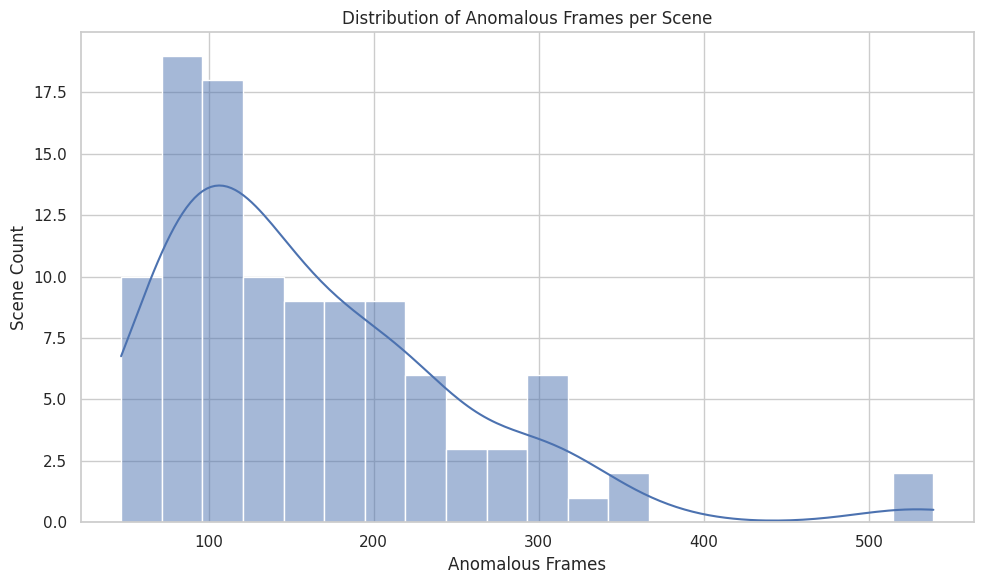

In [30]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(df["Anomalous Frames"], bins=20, kde=True)
plt.title("Distribution of Anomalous Frames per Scene")
plt.xlabel("Anomalous Frames")
plt.ylabel("Scene Count")
plt.tight_layout()
plt.show()


### Analysis 2:  Anomaly Segments vs. Anomalous Frames (with Longest Anomaly Highlighted) 

The figure illustrates the relationship between the number of detected anomaly segments and the total number of anomalous frames per scene. Notably, most scenes exhibit only one or two anomaly segments, even when the total number of anomalous frames is high. This indicates that anomalies often occur as sustained, contiguous events rather than being scattered across multiple seperate intervals. Furthermore, the color scale representing the longest anomaly duration confirms: scenes with higher frame-level anomaly counts frequently correspond to a single, long-lasting anomaly segment. These findings support the hypothesis that many anomalous behaviors in the dataset are not isolated, short-lived events but rather prolonged sequences of abnormal activity. This highlights the need for temporal models capturing long-range dependencies, rather than relying solely on frame-level classification. It also justifies the choice to model scenes as temporal units, rather than treating frames independently.

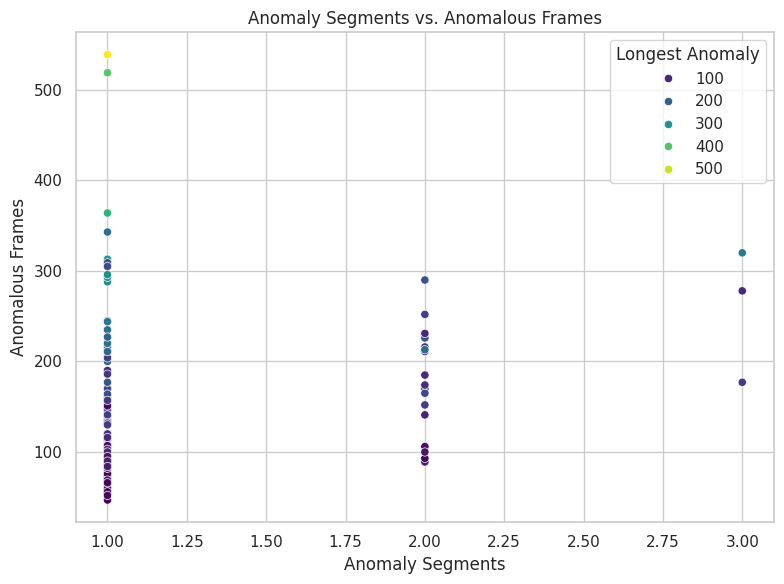

In [37]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Anomaly Segments", y="Anomalous Frames", hue="Longest Anomaly", palette="viridis")
plt.title("Anomaly Segments vs. Anomalous Frames")
plt.xlabel("Anomaly Segments")
plt.ylabel("Anomalous Frames")
plt.tight_layout()
plt.show()

### Analysis 3:Total Frames vs. Anomaly Segments

The plot reveals that most scenes, regardless of their total frame count, contain only one or two anomaly segments, with very few exceeding three. This flat distribution across varying scene lengths suggests that anomalies are temporally clustered within scenes, rather than being spread across many isolated intervals. In other words, longer videos do not necessarily contain more distinct anomaly events; instead, they may simply contain longer or more sustained anomalies.
This finding supports the use of segment-based labeling or temporal modeling strategies, where models focus on detecting the start and end of anomaly intervals rather than making frame-by-frame classifications. It also reinforces the idea that anomaly frequency is not proportional to scene duration, which justifies treating anomalies as rare and discrete events, even in long surveillance sequences. Moreover, it implies that incorporating temporal continuity (e.g. temporal convolution, or attention mechanisms) is more meaningful than relying solely on individual frame-level thresholds. For these reasons long scenes do not require special reweighting for anomaly frequency, as segment density remains consistent across durations.

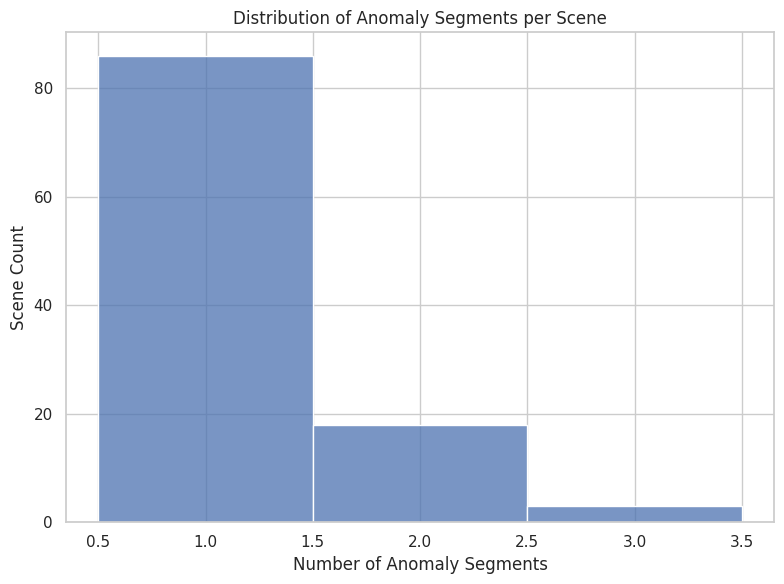

In [41]:
plt.figure(figsize=(8, 6))
sns.histplot(df["Anomaly Segments"], bins=range(1, df["Anomaly Segments"].max() + 2), discrete=True, kde=False)
plt.title("Distribution of Anomaly Segments per Scene")
plt.xlabel("Number of Anomaly Segments")
plt.ylabel("Scene Count")
plt.tight_layout()
plt.show()

### Analysis 4: Distribution of Anomaly Percentage per Scene

The histogram of anomaly percentage per scene reveals considerable variability in how anomalous activity is distributed across the dataset. While many scenes exhibit anomaly rates between 20% and 60%, a notable number of scenes exceed this range, with some approaching or reaching 100% anomalous frames. This right-skewed distribution highlights a lack of uniformity in anomaly density, indicating that there is no single “typical” anomaly rate applicable across all scenes. Such heterogeneity presents challenges for training anomaly detection models, as scenes with disproportionately high anomaly coverage may introduce bias or dominate the learning process if not handled carefully. 

The presence of this long tail suggests that per-scene anomaly behavior must be taken into account. (stratified sampling, weighting schemes, or normalizing contributions during training) Additionally, the uneven distribution reinforces the need for soft, probabilistic anomaly scoring methods, rather than strict binary classification, and supports the use of temporal models that can adapt to varying anomaly frequencies across different video contexts. This variability also justifies scene-aware evaluation protocols to ensure fair and generalizable performance assessment.

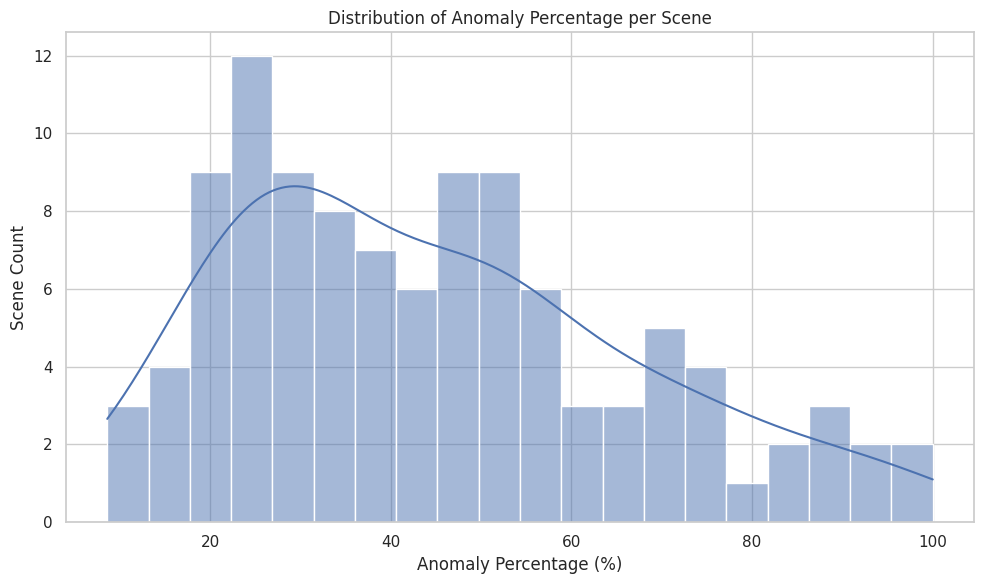

In [35]:
df["Anomaly %"] = df["Anomalous Frames"] / df["Total Frames"] * 100

plt.figure(figsize=(10, 6))
sns.histplot(df["Anomaly %"], bins=20, kde=True)
plt.title("Distribution of Anomaly Percentage per Scene")
plt.xlabel("Anomaly Percentage (%)")
plt.ylabel("Scene Count")
plt.tight_layout()
plt.show()


### Analysis 5: Distribution of Average Anomaly Size (px)

The distribution of average anomaly size per scene is heavily right-skewed, with most scenes exhibiting relatively small anomaly regions—typically under 5,000 pixels in area. This suggests that in the majority of cases, anomalies are spatially localized, likely corresponding to small-scale or object-level abnormal behaviors (e.g., a person running, a bicycle appearing in a pedestrian zone). However, a long tail of larger anomaly sizes is also present, with a few scenes containing anomalies spanning over 20,000 pixels. These larger instances likely correspond to significant or widespread motion across the frame, such as group events or vehicle movement. This distribution highlights the importance of designing pixel-level anomaly detection models that can handle both fine-grained and large-scale spatial deviations, potentially through multi-scale architectures or spatial attention mechanisms. (how to incorparte this

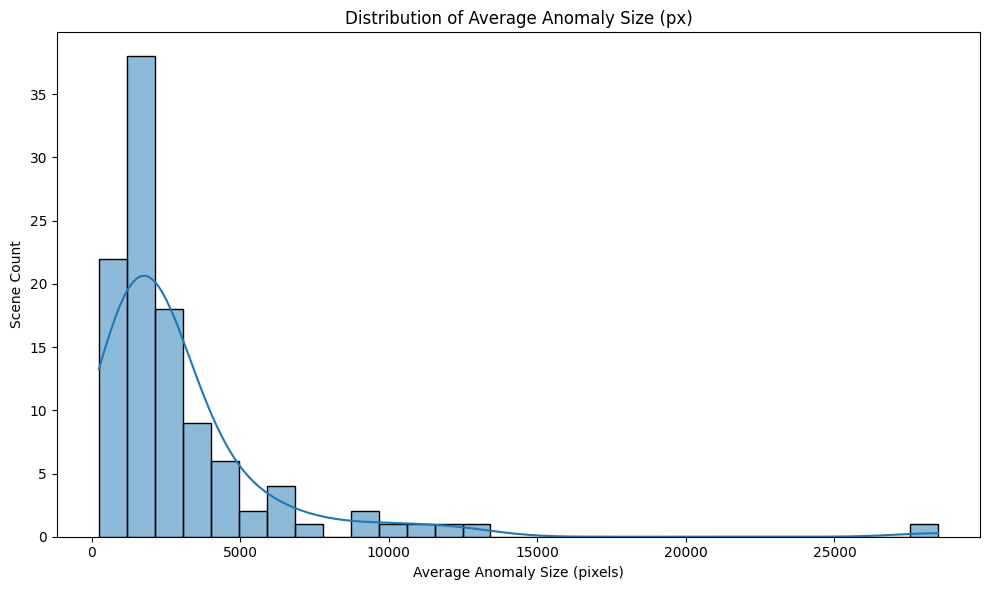

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(df["Avg Anomaly Size (px)"], bins=30, kde=True)
plt.title("Distribution of Average Anomaly Size (px)")
plt.xlabel("Average Anomaly Size (pixels)")
plt.ylabel("Scene Count")
plt.tight_layout()
plt.show()


### Analysis 6: Brightness Std vs. Anomalous Frame Count

The plot reveals no strong correlation between brightness variability and anomalous frame count. Scenes with both low and high brightness standard deviation can exhibit either low or high anomaly counts, indicating that anomalies occur in both visually stable and dynamic environments. This suggests that brightness fluctuation alone is not a strong indicator of anomalous behavior. However, there is a mild tendency for scenes with extremely low brightness variability to have slightly lower anomaly counts, which may reflect static or low-activity environments (e.g., empty walkways or corridors). However, the spread of points at higher brightness standard deviation suggests that some visually dynamic scenes (potentially due to motion, crowds, or lighting changes) are more likely to contain anomalies, though this is a weak trend.

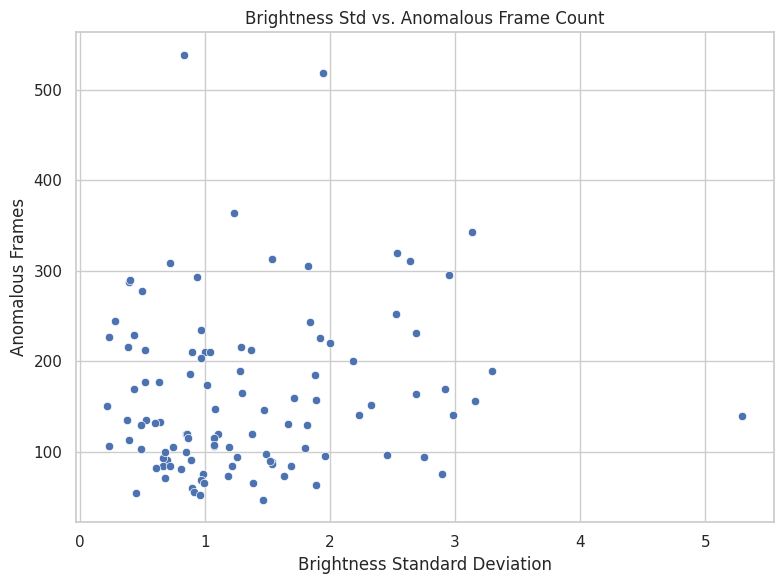

In [32]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Brightness Std", y="Anomalous Frames")
plt.title("Brightness Std vs. Anomalous Frame Count")
plt.xlabel("Brightness Standard Deviation")
plt.ylabel("Anomalous Frames")
plt.tight_layout()
plt.show()



### Analysis 7: Anomalous Frame Ratio vs. Total Frames

The plot illustrates that there is no strong correlation between the total number of frames in a scene and the proportion of anomalous frames. Scenes of both short and long durations can exhibit a wide range of anomaly ratios, with some short scenes being almost entirely anomalous and some long scenes containing very few anomalies. This suggests that scene length is not predictive of anomaly frequency, and that anomaly density is influenced more by the nature of the scene or activity captured than by its duration. The absence of a clear trend underscores the importance of treating anomaly ratio as an independent variable rather than assuming it scales with scene length. Because of this it may be necessary to per-scene normalization or stratified analysis when evaluating models.

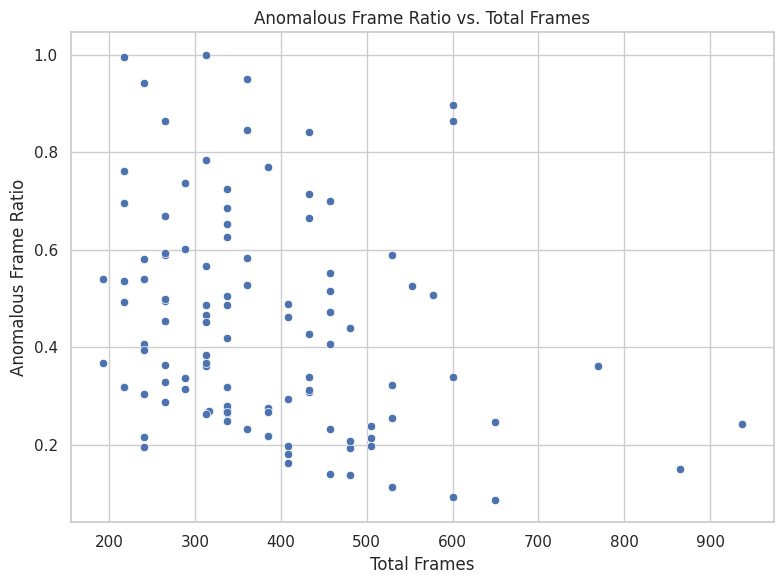

In [31]:
df["Anomaly Ratio"] = df["Anomalous Frames"] / df["Total Frames"]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Total Frames", y="Anomaly Ratio")
plt.title("Anomalous Frame Ratio vs. Total Frames")
plt.xlabel("Total Frames")
plt.ylabel("Anomalous Frame Ratio")
plt.tight_layout()
plt.show()